In [ ]:
import math
import random

In [ ]:
class Value:
    data: float = 0

    def __init__(self, data: float, _children: tuple["Value"]=(), _op: str="", label: str=""):
        self.data = data
        self.grad = 0.0     # derivative of loss fn wrt to this value
        self._backward = lambda: None
        # We're passing tuple but keeping the value as set. Efficiency?
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __add__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other: "Value") -> "Value":  # initially other * self
        return self * other

    def __radd__(self, other: "Value") -> "Value":  # initially other * self
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data;
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(n):
            if n not in visited:
                visited.add(n)
                for child in n._prev:
                    build_topo(child)
                topo.append(n)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
f = Value(-2.0, label="f")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
L = d*f; L.label = "L"
L.backward()

[Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=10.0), Value(data=4.0), Value(data=-2.0), Value(data=-8.0)]


In [ ]:
from graphviz import Digraph

def trace(root: Value):
    """
    Builds a set of all nodes and edges in a graph
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

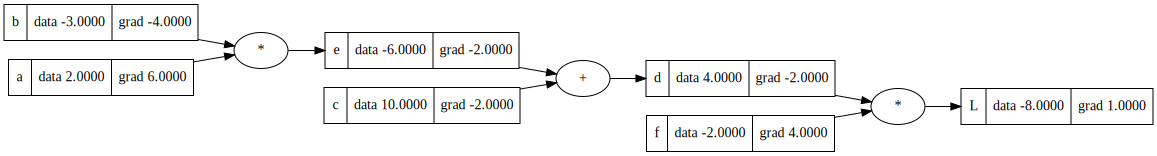

In [ ]:
draw(L)
# L to R is the forward pass
# During backpropagation, we'll find the derivative of L wrt to that node

# Think of L as the loss function.
# We want to see how changes in weights affect the loss function.
# Weights are the children nodes, except for the a and b which represent the input data itself, which cannot change.

In [ ]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0

# dL / da = (dL / de) * (de / da)
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad


    print(k, loss.data)

0 0.017901730617023104
1 0.017873577481663787
2 0.01784782638286242
3 0.01781677715449156
4 0.017793630447830108
5 0.017765043589616905
6 0.017737421584093457
7 0.017706389406556118
8 0.01768269755145322
9 0.017658060010507105
10 0.017630899190087205
11 0.017603383766055455
12 0.0175724592374954
13 0.017545273201396254
14 0.01752153758333066
15 0.01749692321333403
16 0.017464216389968167
17 0.01743465348071131
18 0.017404580492323754
19 0.01737771296386257


In [ ]:
ypred

[Value(data=0.9329573270619815),
 Value(data=-0.9393290338895073),
 Value(data=-0.9354817650775133),
 Value(data=0.9290110980300813)]